In [1]:
SIMPLE_QUERIES = ("gun", "firearm", "gun control", "gun rights", "mass shooting")

In [17]:
import json
from os.path import join

USE_STORED_VALUES = True
if USE_STORED_VALUES:
    with open(join('data', 'search_results.json')) as infile:
        search_results = json.load(infile)
else:
    import time, random
    from urllib.error import HTTPError
    from googlesearch import search, get_random_user_agent
    ua = get_random_user_agent()
    STOP = 240
    search_results = {}
    for q in SIMPLE_QUERIES:
        while True:
            try:
                time.sleep(20 + random.random() * 20)
                search_results[q] = list(search(q, tld='com', lang='en', stop=STOP, pause=10 + random.random() * 40, only_standard=True))
                break # The infinite retry loop
            except HTTPError as e:
                if e.code != 503:
                    raise e
                ua = get_random_user_agent()
                time.sleep(600)

    # Store
    with open(join('data', 'search_results.json'), 'w') as outfile:
        json.dump(search_results, outfile, sort_keys=True,
                  indent=4, separators=(',', ': '))


In [10]:
with open(join('data', 'sources.json')) as infile:
    sources = json.load(infile)

In [35]:
from urllib.parse import urlparse

LAYERS = (0, 5, 25, 70, 150)
BIASES = {
    "left": 0,
    "leftcenter": 1,
    "center": 2,
    "right-center": 3,
    "right": 4,
}
data = []
not_in_sources = set([])
not_in_biases = {}
for q in SIMPLE_QUERIES:
    layers = []
    for li in range(len(LAYERS)-1):
        wi = 1 / (LAYERS[li+1] - LAYERS[li])
        bins = [0, 0, 0, 0, 0]
        for url in search_results[q][LAYERS[li]:LAYERS[li+1]]:
            domain = urlparse(url).netloc
            if domain not in sources and domain.count('.') > 1:
                domain = domain[domain.index('.')+1:]
            if domain not in sources:
                not_in_sources.add(domain)
                continue
            b = sources[domain][0]['bias']
            if b in BIASES:
                bins[BIASES[b]] += wi
            else:
                if b not in not_in_biases:
                    not_in_biases[b] = 1
                else:
                    not_in_biases[b] += 1
        layers.append(bins)
    data.append(layers)

In [39]:
print(len(not_in_sources))
print(not_in_biases)

308
{'pro-science': 21, 'fake-news': 3, 'satire': 1}


<IPython.core.display.Javascript object>


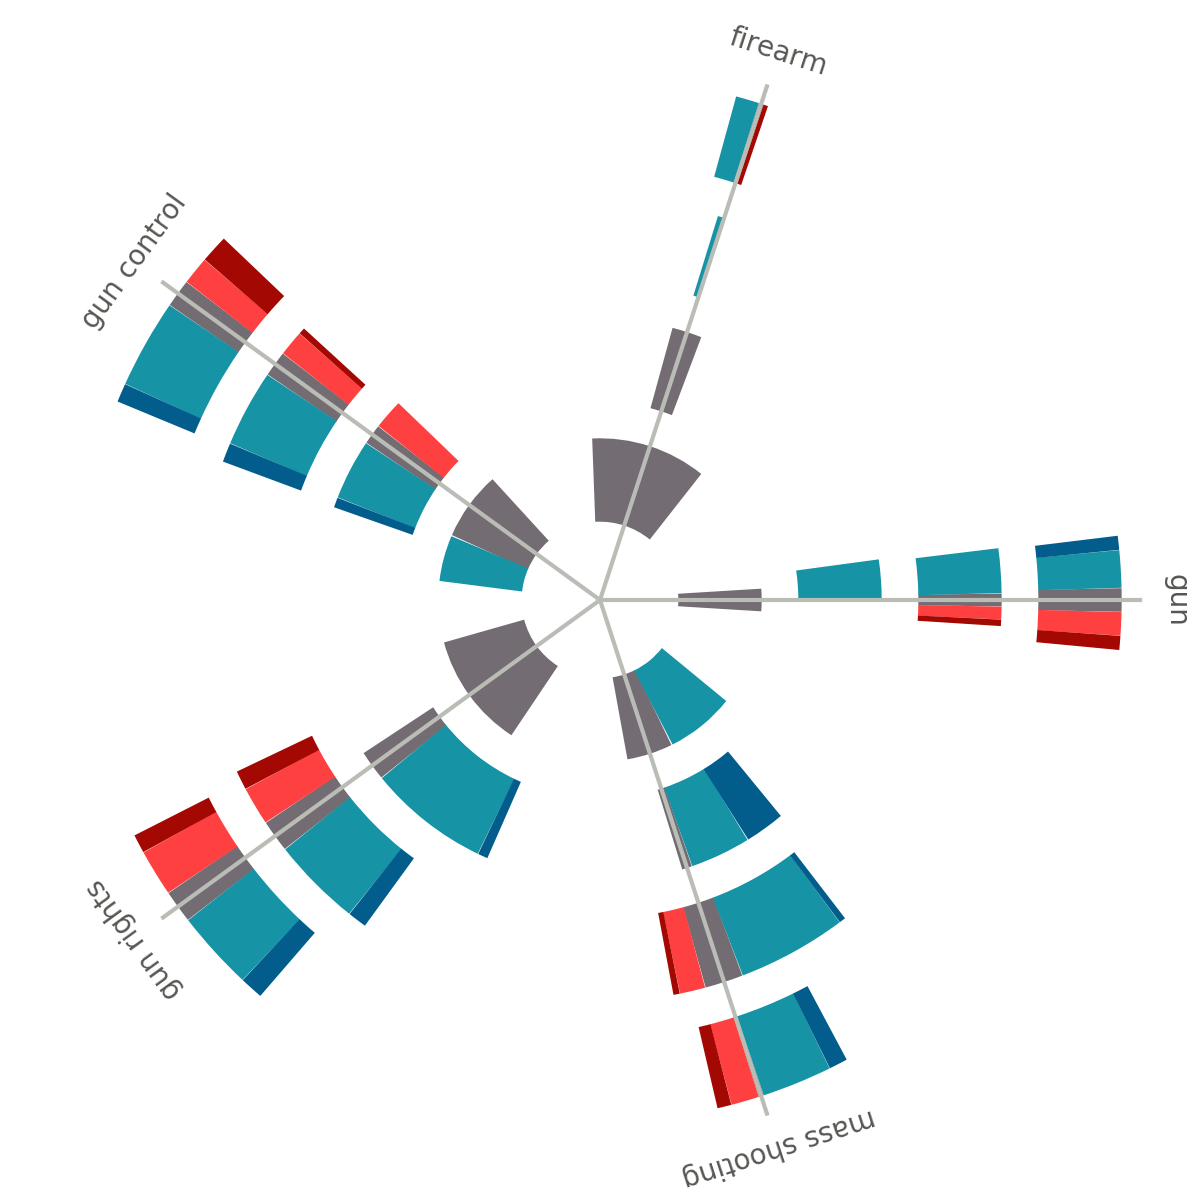

In [34]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc
import matplotlib.lines as lines



def plot_distance_rings(data, axes=None, colors=None):
    n = len(data)  # number of axes
    ln = len(data[0])  # number of layers
    bn = len(data[0][0])  # number of bins
    w_theta = 210 / n
    lw = 120 / ln

    fig = plt.figure(figsize=(6, 6))
    for i in range(n):
        theta = 360 * i / n
        theta_r = 2 * np.pi * i / n
        l = lines.Line2D((0.5, .45*np.cos(theta_r)+.5), (0.5, .45*np.sin(theta_r)+.5),
                     color='#babdb6', transform=fig.transFigure)
        if axes:
            rotation = (theta - 90) % 360
            fig.text(.48*np.cos(theta_r)+.5, .48*np.sin(theta_r)+.5, axes[i],
                     horizontalalignment='center', verticalalignment='center',
                     rotation=rotation, color='#555753', transform=fig.transFigure)

        fig.lines.append(l)
        for j in range(ln):
            arcs = []
            right = left = theta
            rw = (j+1) / (ln+1)
            d = data[i][j]
            if bn % 2 == 1:
                c = 'gray'
                if colors:
                    c = colors[bn//2]
                a = Arc((.5, .5), rw, rw, theta1=right-(w_theta*d[bn//2]/2), theta2=left+(w_theta*d[bn//2]/2),
                         angle=0, linewidth=lw, color=c, fill=False, transform=fig.transFigure)
                arcs.append(a)
                right -= w_theta * d[bn//2]/2
                left += w_theta * d[bn//2]/2
            for k in range(1, 1+bn//2):
                kl = bn//2 - k
                c = 'blue'
                if colors:
                    c = colors[kl]
                a = Arc((.5, .5), rw, rw, theta1=left, theta2=left+w_theta*d[kl],
                         angle=0, linewidth=lw, color=c, fill=False, transform=fig.transFigure)
                arcs.append(a)
                left += w_theta * d[kl]

                kr = bn//2 + k
                c = 'red'
                if colors:
                    c = colors[kr]
                a = Arc((.5, .5), rw, rw, theta1=right-w_theta*d[kr], theta2=right,
                         angle=0, linewidth=lw, color=c, fill=False, transform=fig.transFigure)
                arcs.append(a)
                right -= w_theta * d[kr]
            fig.patches.extend(arcs)
    plt.show()

plot_distance_rings(
    data,
    axes=SIMPLE_QUERIES,
    colors=['#025D8C', '#1693A5', '#746C73', '#FF4040', '#A40802'])